In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

Using TensorFlow backend.


In [2]:
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
 
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [3]:
# load dataset
series = read_csv('shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
 
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [6]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[-0.40692836],
       [-0.08620401],
       [-0.6529265 ],
       [ 0.27945042],
       [-0.23111577],
       [ 0.01864356],
       [-0.36749512],
       [-0.06424578],
       [-0.06459009],
       [ 0.86901224],
       [-0.9572492 ],
       [ 0.04868013],
       [-0.282515  ],
       [ 0.25176597],
       [-0.25961018],
       [-0.16748664],
       [ 0.06688824],
       [-0.37443167],
       [ 0.4083925 ],
       [-0.23779605],
       [ 0.01561621],
       [-0.87942153],
       [ 0.0909124 ]], dtype=float32)

In [7]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Month=1, Predicted=289.603702, Expected=339.700000
Month=2, Predicted=356.042046, Expected=440.400000
Month=3, Predicted=333.932180, Expected=315.900000
Month=4, Predicted=333.000514, Expected=439.300000
Month=5, Predicted=290.346755, Expected=401.300000
Month=6, Predicted=417.642046, Expected=437.400000
Month=7, Predicted=290.490064, Expected=575.500000
Month=8, Predicted=510.637809, Expected=407.600000
Month=9, Predicted=243.547404, Expected=682.000000
Month=10, Predicted=535.950715, Expected=475.300000
Month=11, Predicted=478.308941, Expected=581.300000
Month=12, Predicted=406.043513, Expected=646.900000


Test RMSE: 180.356


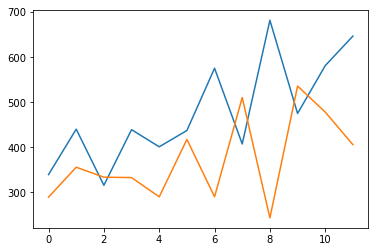

In [8]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()

In [9]:
# repeat experiment
repeats = 30
error_scores = list()
for r in range(repeats):
    # fit the model
    lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)
    # walk-forward validation on the test data
    predictions = list()
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
    # report performance
    rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)

1) Test RMSE: 98.769
2) Test RMSE: 123.119
3) Test RMSE: 106.178
4) Test RMSE: 168.611
5) Test RMSE: 72.715
6) Test RMSE: 107.200
7) Test RMSE: 140.232
8) Test RMSE: 94.804
9) Test RMSE: 111.458
10) Test RMSE: 164.225
11) Test RMSE: 179.747
12) Test RMSE: 134.429
13) Test RMSE: 133.093
14) Test RMSE: 91.709
15) Test RMSE: 210.401
16) Test RMSE: 292.096
17) Test RMSE: 92.616
18) Test RMSE: 163.594
19) Test RMSE: 155.264
20) Test RMSE: 118.556
21) Test RMSE: 188.956
22) Test RMSE: 111.799
23) Test RMSE: 149.828
24) Test RMSE: 169.369
25) Test RMSE: 86.785
26) Test RMSE: 104.750
27) Test RMSE: 151.031
28) Test RMSE: 106.980
29) Test RMSE: 115.632
30) Test RMSE: 92.531


                      rmse
count            30.000000
mean            134.549347
std              45.471799
min              72.715432
25%             105.107222
50%             120.837311
75%             161.511865
max             292.095803


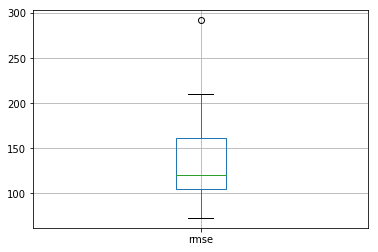

In [10]:
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()